In [1]:
import time
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox, networkx as nx
import ast
import statistics
import numpy as np
from sklearn.neighbors import BallTree
from shapely.geometry import Point
import random
import matplotlib.path as mpltPath
import json 

ox.config(use_cache=True, log_console=True)
print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.8.2
nx 2.1


# Get all TAZs for the Bay Area and all trips from the Bay Area MTC

In [2]:
taz_loc_df = pd.read_csv("Traffic_Analysis_Zones.csv")
trips_df = pd.read_csv("indivTripData_3.csv")

In [ ]:
trips_df.head()

# Narrow down trips to only morning trips between 8-9am (morning peak) and also only to car trips (both driving and ridesharing)

In [4]:
#get only peak morning trips and the shape
depart_hour = 8
morning_peak = trips_df[(trips_df.depart_hour == depart_hour)] #| (trips_df.depart_hour == 9)]
morning_peak.shape

time_string = '{}to{}'.format(depart_hour, depart_hour + 1)

In [5]:
#get full car trips from O to D (this includes ridesharing, but does not include car to another form of transit)
morning_peak = morning_peak[morning_peak.trip_mode < 7]
morning_peak.shape

(866375, 18)

In [6]:
morning_peak.head()

,hh_id,person_id,person_num,tour_id,stop_id,inbound,tour_purpose,orig_purpose,dest_purpose,orig_taz,orig_walk_segment,dest_taz,dest_walk_segment,parking_taz,depart_hour,trip_mode,tour_mode,tour_category
6,1213144,2741557,1,0,1,0,work_med,escort,work,11,1,16,1,0,8,3,3,MANDATORY
61,730660,1422398,1,0,0,0,work_med,Home,work,1,1,22,1,0,8,1,3,MANDATORY
62,730660,1422398,1,0,1,0,work_med,work,work,22,1,16,1,0,8,1,3,MANDATORY
64,225308,300174,1,0,-1,0,university,Home,university,1,1,12,1,0,8,1,1,MANDATORY
65,225308,300174,1,0,-1,1,university,university,Home,12,1,1,1,0,8,1,1,MANDATORY


# Create functions to find the nodes that are within the polygons of each TAZ

In [7]:
def find_in_nodes(row, points, nodes_df):
    ### return the indices of points in nodes_df that are contained in row['geometry']
    if row['geometry'].type == 'MultiPolygon':
        return []
    else:
        path = mpltPath.Path(list(zip(*row['geometry'].exterior.coords.xy)))
        in_index = path.contains_points(points)
        return nodes_df['osmid'].loc[in_index].tolist()


def taz_nodes():
    ### Find corresponding nodes for each TAZ
    ### Input 1: TAZ polyline
    taz_gdf = gpd.read_file("Travel_Analysis_Zones.shp")
    #taz_gdf = gpd.read_file("san_francisco_taz.json")
    taz_gdf = taz_gdf.to_crs({'init': 'epsg:4326'})

    ### Input 2: OSM nodes coordinate
    nodes_df = pd.read_csv('../new_tertiary/nodes.csv') ### `nodes.csv` from OSMNX
    points = nodes_df[['x', 'y']].values ### x, y are the coordinates of the nodes
    taz_gdf['in_nodes'] = taz_gdf.apply(lambda row: find_in_nodes(row, points, nodes_df), axis=1)
    taz_nodes_dict = {row['TAZ1454']:row['in_nodes'] for index, row in taz_gdf.iterrows()}
    
    return taz_nodes_dict
    ### [{'taz': 1, 'in_nodes': '[...]''}, ...]
    #with open('taz_nodes.json', 'w') as outfile:
    #    json.dump(taz_nodes_dict, outfile, indent=2)

In [8]:
taz_nodes_dict = taz_nodes()

# Count the number of TAZs that do not have any nodes in its network (for informational purposes/sanity check)

In [9]:
#number of TAZ that do not have any nodes in its network
count = 0
for key, value in taz_nodes_dict.items():
    if len(taz_nodes_dict[key]) == 0:
        count += 1
print(count)

91


# Create functions to (a) generate a dataframe containing all OD from TAZ to TAZ, and then (b) randomly assign each O to a particular node in the TAZ and each D to a particular node in the TAZ

In [10]:
#create dataframe of each person with origin TAZ and destination TAZ
def create_od_df(trips_df):
    orig_dest_df = pd.DataFrame(columns=['orig', 'dest'])
    orig_dest_df['orig'] = morning_peak['orig_taz']
    orig_dest_df['dest'] = morning_peak['dest_taz']
    orig_dest_df['person_id'] = morning_peak['person_id']
    orig_dest_df['person_num'] = morning_peak['person_num']
    return orig_dest_df

def assign_node_to_od(od_df, taz_nodes_dict, assign='random'):
    origs = []
    dests = []
    bad_list = []
    for i, row in enumerate(od_df.itertuples(), 0):
        len_network_o = len(taz_nodes_dict[row.orig])
        len_network_d = len(taz_nodes_dict[row.dest])
        if len_network_o == 0 or len_network_d == 0:
            bad_list += [i,]
        else:
            if assign == 'random':
                node_o = random.choice(taz_nodes_dict[row.orig])
                node_d = random.choice(taz_nodes_dict[row.dest])
                #print(node_o)
                #print(node_d)
        
                origs += [node_o,]
                dests += [node_d,]
                
    print("number of OD taz with zero nodes = {}".format(len(bad_list)))
    return origs, dests, bad_list

In [11]:
morning_peak_od_df = create_od_df(morning_peak)
morning_peak_od_df.head()

,orig,dest,person_id,person_num
6,11,16,2741557,1
61,1,22,1422398,1
62,22,16,1422398,1
64,1,12,300174,1
65,12,1,300174,1


In [12]:
new_df = morning_peak_od_df.copy()
new_df.head()

,orig,dest,person_id,person_num
6,11,16,2741557,1
61,1,22,1422398,1
62,22,16,1422398,1
64,1,12,300174,1
65,12,1,300174,1


In [13]:
#create dataframe that contains ODs from randomly assigned node in O taz to randomly assigned node in D taz
start = time.time()
origs, dests, bad_list = assign_node_to_od(new_df, taz_nodes_dict, 'random')
end = time.time()
print("time taken = {}".format(end - start))

number of OD taz with zero nodes = 73465
time taken = 2.2611031532287598


In [32]:
print(len(bad_list))

73465


In [33]:
final_df = morning_peak_od_df.drop(morning_peak_od_df.index[bad_list])


# Make final dataframe that is in the SAMPN, PERNO, orig, dest format of OD for the traffic microsimulator

In [34]:
#create a new dataframe with person id, person num, orig OSMID, and dest OSMID
def make_final_df(origs, dests, morning_peak):
    #osmid_o = [x['osmid'] for x in origs]
    #osmid_d = [x['osmid'] for x in dests]
    final_df = pd.DataFrame(columns=['SAMPN', 'PERNO','orig', 'dest'])
    final_df['SAMPN'] = morning_peak['person_id']
    final_df['PERNO'] = morning_peak['person_num']
    final_df['orig'] = origs
    final_df['dest'] = dests

    return final_df

final_od_file_df = make_final_df(origs, dests, final_df)

In [37]:
final_od_file_df.shape

(792910, 4)

# Save the OD file as od_demand.csv to be used in the traffic microsimulator, cb-cities, and static traffic assignment

In [35]:
#save to csv
final_od_file_df.to_csv('../new_tertiary/od_demand.csv', index=False, encoding='utf-8')

# UNUSED STUFF #

# Check the osmid in nodes.csv and compare to the osmids of origins and destinations in the final_df dataframe to see which ones are there and which ones are not

In [20]:
nodes_df = pd.read_csv("../nodes.csv")

In [31]:
count_vals_orig = final_df.orig.isin(nodes_df.osmid).astype(int)
print("# of origin nodes in OD file not in nodes file = {}".format(count_vals_orig.sum()))

count_vals_dest = final_df.dest.isin(nodes_df.osmid).astype(int)
print("# of dest nodes in OD file not in nodes file = {}".format(count_vals_dest.sum()))
            
#print("orig count not in nodes file = {}".format(orig_count))
#print("dest count not in nodes file = {}".format(dest_count))
#print("total count not in nodes file = {}".format(orig_count + dest_count))

            

# of origin nodes in OD file not in nodes file = 34489
# of dest nodes in OD file not in nodes file = 32103


In [295]:
count = 0
for idx, row in final_od_file_df.iterrows():
    if row['orig'] == row['dest']:
        #print(row['orig'], row['dest'])
        count += 1
        
        
print("# of OD pairs with same src and dest = {}".format(count))

KeyboardInterrupt: 

In [13]:
#create dataframe of each person with origin TAZ and destination TAZ
def create_od_df(trips_df):
    orig_dest_df = pd.DataFrame(columns=['orig', 'dest'])
    orig_dest_df['orig'] = morning_peak['orig_taz']
    orig_dest_df['dest'] = morning_peak['dest_taz']
    return orig_dest_df

def assign_node_to_od(od_df, taz_street_network, assign='random'):
    new_df = od_df.copy()
    origs = []
    dests = []
    for index, row in od_df.iterrows():
        #get the lengths of the networks so that we can randomly choose a number in those ranges
        len_network_o = len(taz_graph_list[row['orig']].nodes())
        len_network_d = len(taz_graph_list[row['dest']].nodes())
        
        if assign == 'random':
            #get the randomly chosen value within the length range
            rand_val_o = randint(0, len_network_o - 1)
            rand_val_d = randint(0, len_network_d - 1)
        
        #make the network nodes of origin and destination taz lists
        list_of_taz_nodes_o = list(taz_graph_list[row['orig']].nodes())
        list_of_taz_nodes_d = list(taz_graph_list[row['dest']].nodes())
        #print(list_of_taz_nodes_o)
        
        #get the OSMID of the nodes from the above lists based on the random value as the index
        taz_graph_node_index_o = list_of_taz_nodes_o[rand_val_o]
        taz_graph_node_index_d = list_of_taz_nodes_d[rand_val_d]
        #print(taz_graph_node_index_o)
        
        #set the new nodes as that person's O and D
        node_o = taz_graph_list[row['orig']].node[taz_graph_node_index_o]
        #print(node_o)
        node_d = taz_graph_list[row['dest']].node[taz_graph_node_index_d]
        #print(node_d)
        
        origs += [node_o,]
        dests += [node_d,]
        
    return origs, dests

In [10]:
#make each TAZ a graph with its street netowrks
taz_graph_list = []
taz_num = 0
start = time.time()
for x in taz['geometry']:
    polygon_hull = x.convex_hull
    polygon_hull_proj, crs = ox.project_geometry(polygon_hull)
    polygon_hull_proj_buff = polygon_hull_proj.buffer(200) #200 meters
    polygon_hull_buff, crs = ox.project_geometry(polygon_hull_proj_buff, crs=crs, to_latlong=True)
    try:
        G = ox.graph_from_polygon(polygon_hull_buff, network_type='drive', simplify=True) 
    except: 
        print('An error occurred.')
    #latlng_geom, _ = ox.project_geometry(taz['geometry'].iloc[0], crs={'init':'epsg:28992'}, to_latlong=True)
    #print("taz num = {}".format(taz_num))
    #print("num nodes = {}".format(len(G.nodes())))
    taz_graph_list += [G,]
    taz_num += 1
end_time = time.time()
print("total time = {}".format(abs(end_time - start_time)))
#ox.plot_graph(G)

An error occurred.
An error occurred.
An error occurred.
An error occurred.
An error occurred.
total time = 3260.290658712387


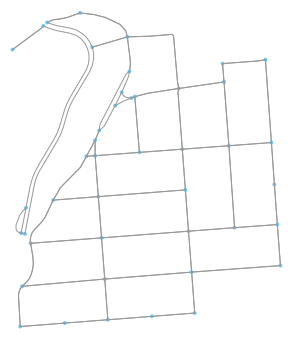

(<Figure size 466.757x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a83ca7320>)

In [11]:
ox.plot_graph(taz_graph_list[400])

In [12]:
taz_graph_list[400].node[65303936]

{'y': 37.7525004, 'x': -122.4407899, 'osmid': 65303936}

# Trying to do the OD assignment in each taz another way

In [28]:
#create full bay area street network
#identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'
          }

In [30]:
# shapefile of counties
counties_shapefile_dir = 'cb_2016_us_county_500k'
counties = gpd.read_file("{}.shp".format(counties_shapefile_dir))
len(counties)

# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

bayarea_polygon = gdf_bay.unary_union



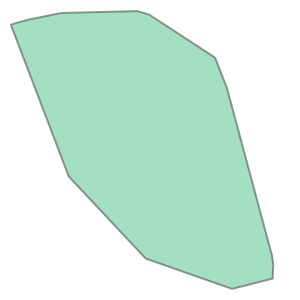

In [31]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon_hull = bayarea_polygon.convex_hull
bayarea_polygon_hull_proj, crs = ox.project_geometry(bayarea_polygon_hull)
bayarea_polygon_hull_proj



In [32]:
# project by a mile to get connectivities surrounding our O-Ds
bayarea_polygon_hull_proj_buff = bayarea_polygon_hull_proj.buffer(1600) #1 mile in meters
bayarea_polygon_hull_buff, crs = ox.project_geometry(bayarea_polygon_hull_proj_buff, crs=crs, to_latlong=True)

In [33]:
#make overall bay area network
G = ox.graph_from_polygon(bayarea_polygon_hull_buff, network_type='drive', simplify=False)

In [34]:
# identify all the edge types we want to retain
types = ['motorway', 'motorway_link', 'trunk', 'trunk_link', 
         'primary', 'primary_link', 'secondary', 'secondary_link',
         'tertiary', 'tertiary_link', 'unclassified', 'road']


#types = ['motorway', 'motorway_link', 
#         'primary', 'primary_link', 'secondary', 'secondary_link',
#         'tertiary', 'tertiary_link']

minor_streets = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if d['highway'] not in types]

In [35]:
# remove minor streets and retain only the largest connected component subgraph
G_ter = G
G_ter.remove_edges_from(minor_streets)
G_ter = ox.remove_isolated_nodes(G_ter)
G_ter_connected = ox.get_largest_component(G_ter, strongly=True)

In [36]:
# then simplify the graph now that we have only the edge types we want
G_ter_simp = ox.simplify_graph(G_ter_connected, strict=True)
#G_ter_simp = G_ter
#G_ter_simp = G

In [81]:
taz.iloc[0]

TAZ                                                      100011
COUNT                                                         1
FIRST_COUN                                                06075
geometry      POLYGON ((-122.3974640322931 37.7936567954638,...
Name: 0, dtype: object

In [108]:
"""
#plot lat-longs on map
def make_point(row):
    return Point(row.long, row.lat)

# Go through every row, and make a point out of its lat and lon
points = .apply(make_point, axis=1)
"""
def create_lat_long_from_graph_nodes(G):
    G_nodes_list = list(G.nodes())
    lat_list = []
    long_list = []
    osmid_list = []
    for x in G_nodes_list:
        lat_list += [G.nodes()[x]['x'],]
        long_list += [G.nodes()[x]['y'],]
        osmid_list += [x,]
        
    return lat_list, long_list, osmid_list

lat_list, long_list, osmid_list = create_lat_long_from_graph_nodes(G_ter_simp)


def make_df_lat_long_osmid(lat, long, osmid):
    final_df = pd.DataFrame(columns=['osmid', 'lat','long'])
    final_df['osmid'] = osmid
    final_df['lat'] = lat
    final_df['long'] = long
    
    return final_df

nodes_df = make_df_lat_long_osmid(lat_list, long_list, osmid_list)
    


#G_ter_simp.nodes()[1377399032]


In [85]:
nodes_df.head()

,osmid,lat,long
0,1377399032,-121.774380,37.241296
1,309330024,-122.354382,37.587447
2,247385812,-122.014411,37.334175
3,247385814,-122.015335,37.335105
4,312410568,-121.741705,37.206184


In [66]:
#plot lat-longs on map
def make_point(row):
    return Point(row.long, row.lat)

# Go through every row, and make a point out of its lat and lon
points = nodes_df.apply(make_point, axis=1)

nodes_points = gpd.GeoDataFrame(nodes_df, geometry=points)
nodes_points.head()

,osmid,lat,long,geometry
0,1377399032,-121.774380,37.241296,POINT (37.2412963 -121.7743797)
1,309330024,-122.354382,37.587447,POINT (37.5874468 -122.3543825)
2,247385812,-122.014411,37.334175,POINT (37.3341754 -122.0144107)
3,247385814,-122.015335,37.335105,POINT (37.3351054 -122.0153351)
4,312410568,-121.741705,37.206184,POINT (37.2061842 -121.7417054)


In [74]:
taz.iloc[0]

TAZ                                                      100011
COUNT                                                         1
FIRST_COUN                                                06075
geometry      POLYGON ((553049.1766163026 4183092.157697582,...
Name: 0, dtype: object

In [86]:
merged_taz_1 = gpd.sjoin(nodes_points, taz.iloc[10], how="left", op="contains")
merged_taz_1.head()
#taz.iloc[0].contains(nodes_points)


AttributeError: 'Series' object has no attribute 'crs'

In [175]:
#get centroid coordinates of each TAZ (x and y)
lats = taz.geometry.centroid.x
longs = taz.geometry.centroid.y

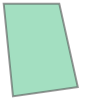

In [176]:
taz.iloc[10]['geometry']

In [177]:
def make_taz_lat_long_df(tazs, lat, long):
    new_df = pd.DataFrame(columns=['taz', 'lat','long'])
    new_df['taz'] = tazs
    new_df['lat'] = lats
    new_df['long'] = longs
    return new_df

centroid_lat_long_df = make_taz_lat_long_df(tazs, lats, longs)

In [178]:
#plot lat-longs on map
def make_point(row):
    return Point(row.long, row.lat)

# Go through every row, and make a point out of its lat and lon
points = centroid_lat_long_df.apply(make_point, axis=1)

# Make a new GeoDataFrame
# using the data from our old df
# but also adding in the geometry we just made
taz_centroids = gpd.GeoDataFrame(centroid_lat_long_df, geometry=points)

# It doesn't come with a CRS because it's a CSV, so let's
# say "hey, let's use the standard shape of the earth etc"
taz_centroids.crs = {'init': 'epsg:4326'}
    

#look at the first few
taz_centroids.head(n=100)

,taz,lat,long,geometry
0,100011,-122.398114,37.794007,POINT (37.79400678832175 -122.398114042965)
1,100012,-122.399327,37.793833,POINT (37.79383262307944 -122.3993267183066)
2,100013,-122.400521,37.793938,POINT (37.79393775629128 -122.4005212162663)
3,100014,-122.400436,37.793453,POINT (37.79345342856071 -122.4004363853933)
4,100015,-122.401614,37.793307,POINT (37.79330682952443 -122.4016140830772)
5,100016,-122.401714,37.793757,POINT (37.79375681617553 -122.4017140874718)
6,100017,-122.402743,37.793610,POINT (37.79361034758903 -122.4027425033998)
7,100018,-122.402614,37.793157,POINT (37.79315683977168 -122.4026140948322)
8,100019,-122.403500,37.793262,POINT (37.79326225814949 -122.4034999402384)
9,10001A,-122.404384,37.793192,POINT (37.79319234410282 -122.4043837573567)


(36.87615263293962,
 38.935025429778776,
 -123.57943972389029,
 -121.39556355772304)

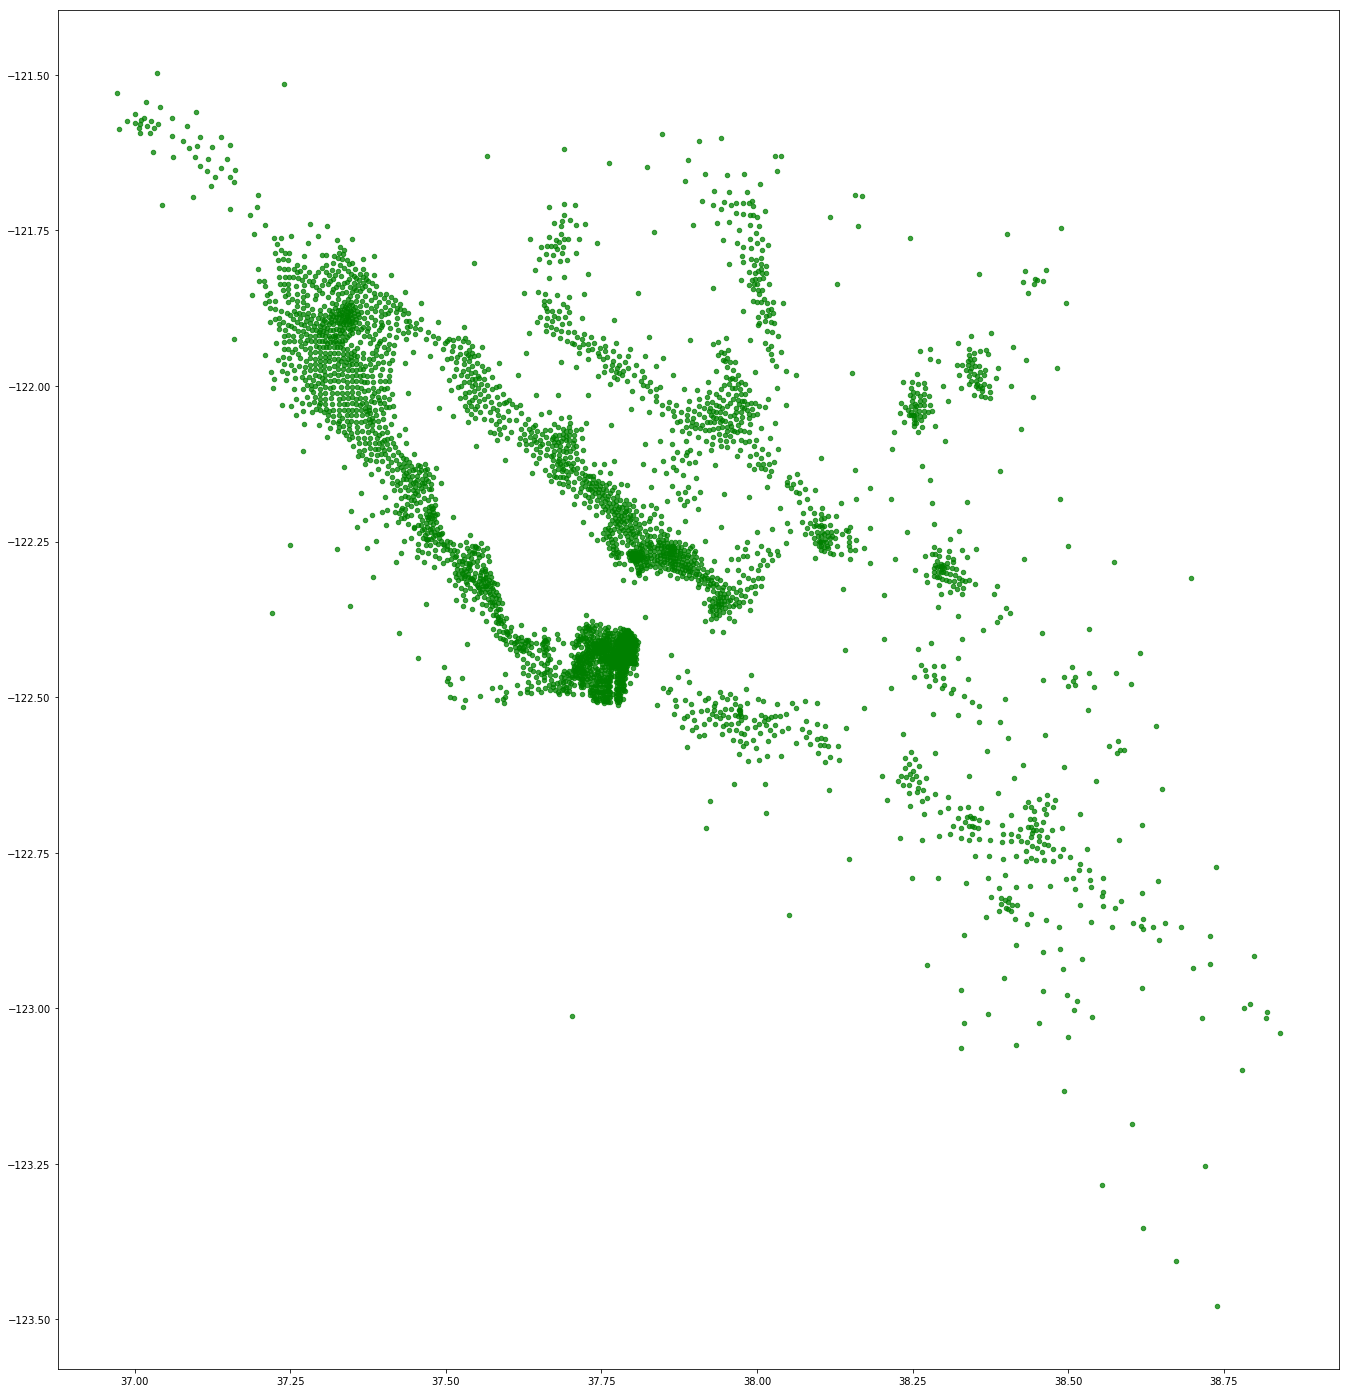

In [179]:
#plot taz centroids lat-long
ax = taz_centroids.plot(figsize=(25,25), markersize=20, color='green', alpha=0.75)
ax.axis('on')

In [121]:
#taz_loc_df.sort_values('taz')

In [180]:
taz['geometry']

0       POLYGON ((-122.3974640322931 37.7936567954638,...
1       POLYGON ((-122.3986640463337 37.79345680835092...
2       POLYGON ((-122.3999640650276 37.79375680637731...
3       POLYGON ((-122.4009640737312 37.79315683050976...
4       POLYGON ((-122.4009640737312 37.79315683050976...
5       POLYGON ((-122.4022640924444 37.79345682852881...
6       POLYGON ((-122.4022640924444 37.79345682852881...
7       POLYGON ((-122.4029640972087 37.79285685101635...
8       POLYGON ((-122.4029640972087 37.79285685101635...
9       POLYGON ((-122.4047641187705 37.79265686732844...
10      POLYGON ((-122.4055641354295 37.79355684392483...
11      POLYGON ((-122.4052641179977 37.79165690113692...
12      POLYGON ((-122.4029640972087 37.79285685101635...
13      POLYGON ((-122.4029640972087 37.79285685101635...
14      POLYGON ((-122.4009640737312 37.79315683050976...
15      POLYGON ((-122.3997640590638 37.79325682068881...
16      POLYGON ((-122.3983640357851 37.79245683749739...
17      POLYGO

In [118]:
"""
def parse_taz_loc_df_into_lat_long(taz):
    
    new_df = pd.DataFrame(columns=['taz','lat','long'])
    
    for x in taz:
        new_df = pd.DataFrame(columns=['taz','lat','long'])
        new_df['taz'] = x['taz']
        new_df['lat'] = = taz['geometry'][0].split(',')
    
        #remove 'POLYGON' from first element
        new_str[0] = new_str[0].split('N (')[1]

        #get longitude for all values in polygon
        new_str_list = [x.split(' ') for x in new_str]
        #print(new_str_list)

        #remove first element
        del new_str_list[0]

        #remove last element
        del new_str_list[-1]

        #get lat and long
        long = [float(x[1]) for x in new_str_list]
        lat = [float(x[2]) for x in new_str_list]
        #print(new_str[3].split(' '))
        #print(long)
        #print(lat)
        return long, lat


def make_lat_long_df(lat, long):
    new_df = pd.DataFrame(columns=['lat','long'])
    #new_df['segment_id'] = df['PublicSegID']
    new_df['lat'] = lat
    new_df['long'] = long
    return new_df


lat, long = parse_taz_loc_df_into_lat_long(taz_loc_df)
lat_long_df = make_lat_long_df(lat, long)
lat_long_df
"""

"\ndef parse_taz_loc_df_into_lat_long(taz):\n    \n    new_df = pd.DataFrame(columns=['taz','lat','long'])\n    \n    for x in taz:\n        new_df = pd.DataFrame(columns=['taz','lat','long'])\n        new_df['taz'] = x['taz']\n        new_df['lat'] = = taz['geometry'][0].split(',')\n    \n        #remove 'POLYGON' from first element\n        new_str[0] = new_str[0].split('N (')[1]\n\n        #get longitude for all values in polygon\n        new_str_list = [x.split(' ') for x in new_str]\n        #print(new_str_list)\n\n        #remove first element\n        del new_str_list[0]\n\n        #remove last element\n        del new_str_list[-1]\n\n        #get lat and long\n        long = [float(x[1]) for x in new_str_list]\n        lat = [float(x[2]) for x in new_str_list]\n        #print(new_str[3].split(' '))\n        #print(long)\n        #print(lat)\n        return long, lat\n\n\ndef make_lat_long_df(lat, long):\n    new_df = pd.DataFrame(columns=['lat','long'])\n    #new_df['segment_id